# 使用动转静完成以图搜图

作者: [PaddlePaddle](https://github.com/PaddlePaddle)

日期: 2022.5

摘要: 本示例简要介绍如何通过飞桨开源框架，使用动转静功能，完成图片搜索。

## 一、简要介绍

在深度学习模型开发中，动态图代码更易编写和debug，但在部署性能上，静态图更具优势。而飞桨框架支持动态图转静态图（下文简称动转静）的功能，支持使用动态图编写组网代码，飞桨框架会对代码进行分析，自动转换为静态图网络结构，兼顾了动态图易用性和静态图部署性能两方面优势。

本示例简要介绍如何通过飞桨开源框架，使用动转静功能，完成图片搜索的部署。

本示例中的的大部分代码都源于 [基于图片相似度的图片搜索](https://www.paddlepaddle.org.cn/documentation/docs/zh/tutorial/cv_case/image_search/image_search.html) ，如果你想要了解关于组网和训练的更多信息，可以参考该示例。本示例将重点介绍，如何使用动转静完成模型的部署。

关于动转静的更多文档，可以参考：[动态图转静态图-使用文档](https://www.paddlepaddle.org.cn/documentation/docs/zh/guides/04_dygraph_to_static/index_cn.html)

## 二、环境配置

In [ ]:
import paddle
import paddle.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict

print(paddle.__version__)

2.3.0


## 三、数据加载

### 3.1 数据集介绍

本示例采用 [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) 数据集。

In [ ]:
import paddle.vision.transforms as T

transform = T.Compose([T.Transpose((2, 0, 1))])

cifar10_train = paddle.vision.datasets.Cifar10(
    mode="train", transform=transform
)
x_train = np.zeros((50000, 3, 32, 32))
y_train = np.zeros((50000, 1), dtype="int32")

for i in range(len(cifar10_train)):
    train_image, train_label = cifar10_train[i]

    # normalize the data
    x_train[i, :, :, :] = train_image / 255.0
    y_train[i, 0] = train_label

y_train = np.squeeze(y_train)

cifar10_test = paddle.vision.datasets.cifar.Cifar10(
    mode="test", transform=transform
)
x_test = np.zeros((10000, 3, 32, 32), dtype="float32")
y_test = np.zeros((10000, 1), dtype="int64")

for i in range(len(cifar10_test)):
    test_image, test_label = cifar10_test[i]

    # normalize the data
    x_test[i, :, :, :] = test_image / 255.0
    y_test[i, 0] = test_label

y_test = np.squeeze(y_test)

height_width = 32


def show_collage(examples):
    box_size = height_width + 2
    num_rows, num_cols = examples.shape[:2]

    collage = Image.new(
        mode="RGB",
        size=(num_cols * box_size, num_rows * box_size),
        color=(255, 255, 255),
    )
    for row_idx in range(num_rows):
        for col_idx in range(num_cols):
            array = (np.array(examples[row_idx, col_idx]) * 255).astype(
                np.uint8
            )
            array = array.transpose(1, 2, 0)
            collage.paste(
                Image.fromarray(array), (col_idx * box_size, row_idx * box_size)
            )

    collage = collage.resize((2 * num_cols * box_size, 2 * num_rows * box_size))
    return collage


sample_idxs = np.random.randint(0, 50000, size=(5, 5))
examples = x_train[sample_idxs]
show_collage(examples)

### 3.2 构建训练数据
图片检索的模型的训练样本跟常见的分类任务的训练样本不太一样的地方在于，每个训练样本并不是一个(image, class)这样的形式。而是（image0, image1, similary_or_not)的形式，即，每一个训练样本由两张图片组成，而其label是这两张图片是否相似的标志位（0或者1）。

很自然的能够想到，来自同一个类别的两张图片，是相似的图片，而来自不同类别的两张图片，应该是不相似的图片。

为了能够方便的抽样出相似图片（以及不相似图片）的样本，先建立能够根据类别找到该类别下所有图片的索引。

In [ ]:
class_idx_to_train_idxs = defaultdict(list)
for y_train_idx, y in enumerate(y_train):
    class_idx_to_train_idxs[y].append(y_train_idx)

class_idx_to_test_idxs = defaultdict(list)
for y_test_idx, y in enumerate(y_test):
    class_idx_to_test_idxs[y].append(y_test_idx)

num_classes = 10


def reader_creator(num_batchs):
    def reader():
        iter_step = 0
        while True:
            if iter_step >= num_batchs:
                break
            iter_step += 1
            x = np.empty(
                (2, num_classes, 3, height_width, height_width),
                dtype=np.float32,
            )
            for class_idx in range(num_classes):
                examples_for_class = class_idx_to_train_idxs[class_idx]
                anchor_idx = random.choice(examples_for_class)
                positive_idx = random.choice(examples_for_class)
                while positive_idx == anchor_idx:
                    positive_idx = random.choice(examples_for_class)
                x[0, class_idx] = x_train[anchor_idx]
                x[1, class_idx] = x_train[positive_idx]
            yield x

    return reader


def anchor_positive_pairs(num_batchs=100):
    return reader_creator(num_batchs)


pairs_train_reader = anchor_positive_pairs(num_batchs=1000)

## 四、模型组网：把图片转换为高维的向量表示的网络
目标是首先把图片转换为高维空间的表示，然后计算图片在高维空间表示时的相似度。 下面的网络结构用来把一个形状为(3, 32, 32)的图片转换成形状为(8,)的向量。在有些资料中也会把这个转换成的向量称为Embedding，请注意，这与自然语言处理领域的词向量的区别。 下面的模型由三个连续的卷积加一个全局均值池化，然后用一个线性全链接层映射到维数为8的向量空间。为了后续计算余弦相似度时的便利，还在最后做了归一化。（即，余弦相似度的分母部分）

In [ ]:
class MyNet(paddle.nn.Layer):
    def __init__(self):
        super().__init__()

        self.conv1 = paddle.nn.Conv2D(
            in_channels=3, out_channels=32, kernel_size=(3, 3), stride=2
        )

        self.conv2 = paddle.nn.Conv2D(
            in_channels=32, out_channels=64, kernel_size=(3, 3), stride=2
        )

        self.conv3 = paddle.nn.Conv2D(
            in_channels=64, out_channels=128, kernel_size=(3, 3), stride=2
        )

        self.gloabl_pool = paddle.nn.AdaptiveAvgPool2D((1, 1))

        self.fc1 = paddle.nn.Linear(in_features=128, out_features=8)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.gloabl_pool(x)
        x = paddle.squeeze(x, axis=[2, 3])
        x = self.fc1(x)
        x = x / paddle.norm(x, axis=1, keepdim=True)
        return x

## 五、模型训练

In [ ]:
def train(model):
    print("start training ... ")
    model.train()

    inverse_temperature = paddle.to_tensor(
        np.array([1.0 / 0.2], dtype="float32")
    )

    epoch_num = 20

    opt = paddle.optimizer.Adam(
        learning_rate=0.0001, parameters=model.parameters()
    )

    for epoch in range(epoch_num):
        for batch_id, data in enumerate(pairs_train_reader()):
            anchors_data, positives_data = data[0], data[1]

            anchors = paddle.to_tensor(anchors_data)
            positives = paddle.to_tensor(positives_data)

            anchor_embeddings = model(anchors)
            positive_embeddings = model(positives)

            similarities = paddle.matmul(
                anchor_embeddings, positive_embeddings, transpose_y=True
            )
            similarities = paddle.multiply(similarities, inverse_temperature)

            sparse_labels = paddle.arange(0, num_classes, dtype="int64")

            loss = F.cross_entropy(similarities, sparse_labels)

            if batch_id % 500 == 0:
                print(
                    "epoch: {}, batch_id: {}, loss is: {}".format(
                        epoch, batch_id, loss.numpy()
                    )
                )
            loss.backward()
            opt.step()
            opt.clear_grad()


model = MyNet()
train(model)

W0509 17:48:43.776103   262 gpu_context.cc:278] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W0509 17:48:43.782135   262 gpu_context.cc:306] device: 0, cuDNN Version: 7.6.


start training ... 
epoch: 0, batch_id: 0, loss is: [2.3171952]
epoch: 0, batch_id: 500, loss is: [2.6398063]
epoch: 1, batch_id: 0, loss is: [2.0013313]
epoch: 1, batch_id: 500, loss is: [2.1278965]
epoch: 2, batch_id: 0, loss is: [1.9644079]
epoch: 2, batch_id: 500, loss is: [2.0817497]
epoch: 3, batch_id: 0, loss is: [1.9862721]
epoch: 3, batch_id: 500, loss is: [1.9332511]
epoch: 4, batch_id: 0, loss is: [1.6979222]
epoch: 4, batch_id: 500, loss is: [2.0013742]
epoch: 5, batch_id: 0, loss is: [1.851933]
epoch: 5, batch_id: 500, loss is: [2.0790138]
epoch: 6, batch_id: 0, loss is: [2.0263815]
epoch: 6, batch_id: 500, loss is: [2.4864852]
epoch: 7, batch_id: 0, loss is: [1.832271]
epoch: 7, batch_id: 500, loss is: [1.9104774]
epoch: 8, batch_id: 0, loss is: [1.6859345]
epoch: 8, batch_id: 500, loss is: [2.0146108]
epoch: 9, batch_id: 0, loss is: [1.5393345]
epoch: 9, batch_id: 500, loss is: [1.813369]
epoch: 10, batch_id: 0, loss is: [2.0740242]
epoch: 10, batch_id: 500, loss is: [2.

## 六、模型预测
前述的模型训练训练结束之后，就可以用该网络结构来计算出任意一张图片的高维向量表示（embedding)，通过计算该图片与图片库中其他图片的高维向量表示之间的相似度，就可以按照相似程度进行排序，排序越靠前，则相似程度越高。

下面对测试集中所有的图片都两两计算相似度，然后选一部分相似的图片展示出来。

In [ ]:
near_neighbours_per_example = 10

x_test_t = paddle.to_tensor(x_test)
test_images_embeddings = model(x_test_t)
similarities_matrix = paddle.matmul(
    test_images_embeddings, test_images_embeddings, transpose_y=True
)

indicies = paddle.argsort(similarities_matrix, descending=True)
indicies = indicies.numpy()

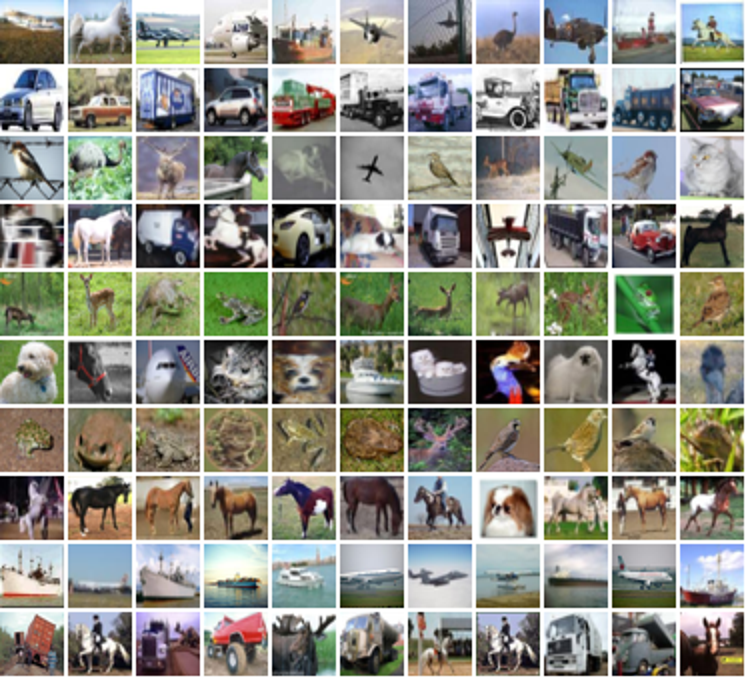

In [ ]:
examples = np.empty(
    (
        num_classes,
        near_neighbours_per_example + 1,
        3,
        height_width,
        height_width,
    ),
    dtype=np.float32,
)

for row_idx in range(num_classes):
    examples_for_class = class_idx_to_test_idxs[row_idx]
    anchor_idx = random.choice(examples_for_class)

    examples[row_idx, 0] = x_test[anchor_idx]
    anchor_near_neighbours = indicies[anchor_idx][
        1 : near_neighbours_per_example + 1
    ]
    for col_idx, nn_idx in enumerate(anchor_near_neighbours):
        examples[row_idx, col_idx + 1] = x_test[nn_idx]

show_collage(examples)

## 七、使用 paddle.jit.to_static 实现动转静

飞桨推荐使用 `@paddle.jit.to_static` 实现动转静，也被称为基于源代码转写的动态图转静态图，其基本原理是通过分析 Python 代码来将动态图代码转写为静态图代码，并在底层自动使用执行器运行，使用起来非常方便，只需要在原网络结构的 `forward` 前添加一个装饰器 `paddle.jit.to_static` 即可。

### 7.1 改写组网代码

In [ ]:
class MyNet2(paddle.nn.Layer):
    def __init__(self):
        super().__init__()

        self.conv1 = paddle.nn.Conv2D(
            in_channels=3, out_channels=32, kernel_size=(3, 3), stride=2
        )

        self.conv2 = paddle.nn.Conv2D(
            in_channels=32, out_channels=64, kernel_size=(3, 3), stride=2
        )

        self.conv3 = paddle.nn.Conv2D(
            in_channels=64, out_channels=128, kernel_size=(3, 3), stride=2
        )

        self.gloabl_pool = paddle.nn.AdaptiveAvgPool2D((1, 1))

        self.fc1 = paddle.nn.Linear(in_features=128, out_features=8)

    # 在forward 前添加 paddle.jit.to_static 装饰器
    @paddle.jit.to_static()
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.gloabl_pool(x)
        x = paddle.squeeze(x, axis=[2, 3])
        x = self.fc1(x)
        x = x / paddle.norm(x, axis=1, keepdim=True)
        return x

通过 `model.summary` 查看网络结构。

In [ ]:
model_2 = MyNet2()
model_info = paddle.summary(model_2, (10, 3, 32, 32))
print(model_info)

-------------------------------------------------------------------------------
   Layer (type)         Input Shape          Output Shape         Param #    
     Conv2D-4        [[10, 3, 32, 32]]     [10, 32, 15, 15]         896      
     Conv2D-5        [[10, 32, 15, 15]]     [10, 64, 7, 7]        18,496     
     Conv2D-6         [[10, 64, 7, 7]]     [10, 128, 3, 3]        73,856     
AdaptiveAvgPool2D-2  [[10, 128, 3, 3]]     [10, 128, 1, 1]           0       
     Linear-2           [[10, 128]]            [10, 8]             1,032     
Total params: 94,280
Trainable params: 94,280
Non-trainable params: 0
-------------------------------------------------------------------------------
Input size (MB): 0.12
Forward/backward pass size (MB): 0.89
Params size (MB): 0.36
Estimated Total Size (MB): 1.36
-------------------------------------------------------------------------------

{'total_params': 94280, 'trainable_params': 94280}


### 7.2 模型训练
使用 paddle.jit.to_static 装饰器后，训练方式仍与原动态图训练一致。因此这里直接传入 `model_2` 完成模型的训练。

In [ ]:
train(model_2)

start training ... 
epoch: 0, batch_id: 0, loss is: [2.2965732]
epoch: 0, batch_id: 500, loss is: [2.189703]
epoch: 1, batch_id: 0, loss is: [2.194418]
epoch: 1, batch_id: 500, loss is: [1.9145985]
epoch: 2, batch_id: 0, loss is: [2.116649]
epoch: 2, batch_id: 500, loss is: [1.9551041]
epoch: 3, batch_id: 0, loss is: [1.9857067]
epoch: 3, batch_id: 500, loss is: [2.1574688]
epoch: 4, batch_id: 0, loss is: [2.1857018]
epoch: 4, batch_id: 500, loss is: [2.1411417]
epoch: 5, batch_id: 0, loss is: [1.7811947]
epoch: 5, batch_id: 500, loss is: [1.8850442]
epoch: 6, batch_id: 0, loss is: [1.6314636]
epoch: 6, batch_id: 500, loss is: [2.0564702]
epoch: 7, batch_id: 0, loss is: [2.0022392]
epoch: 7, batch_id: 500, loss is: [1.8067554]
epoch: 8, batch_id: 0, loss is: [1.8904339]
epoch: 8, batch_id: 500, loss is: [1.6143148]
epoch: 9, batch_id: 0, loss is: [1.9460889]
epoch: 9, batch_id: 500, loss is: [2.2741914]
epoch: 10, batch_id: 0, loss is: [2.02537]
epoch: 10, batch_id: 500, loss is: [2.10

### 7.3 使用 `paddle.jit.save` 保存动转静模型
使用 `paddle.jit.to_static` 转换模型后，需要调用 `paddle.jit.save` 将保存模型，以供后续的预测部署。保存后，会产生 `model.pdmodel` 、`model.pdiparams.info`、`model.pdiparams` 三个文件。

In [ ]:
paddle.jit.save(model_2, "model")

### 7.4 使用 `paddle.jit.load` 加载动转静模型

将模型导出后，需要使用 `paddle.jit.load` 加载模型。加载后的模型可以直接用于预测。

In [ ]:
model_2 = paddle.jit.load("model")

### 7.5 使用动转静模型

前述的模型训练训练结束之后，就可以用该网络结构来计算出任意一张图片的高维向量表示（embedding)，通过计算该图片与图片库中其他图片的高维向量表示之间的相似度，就可以按照相似程度进行排序，排序越靠前，则相似程度越高。

下面对测试集中所有的图片都两两计算相似度，然后选一部分相似的图片展示出来。

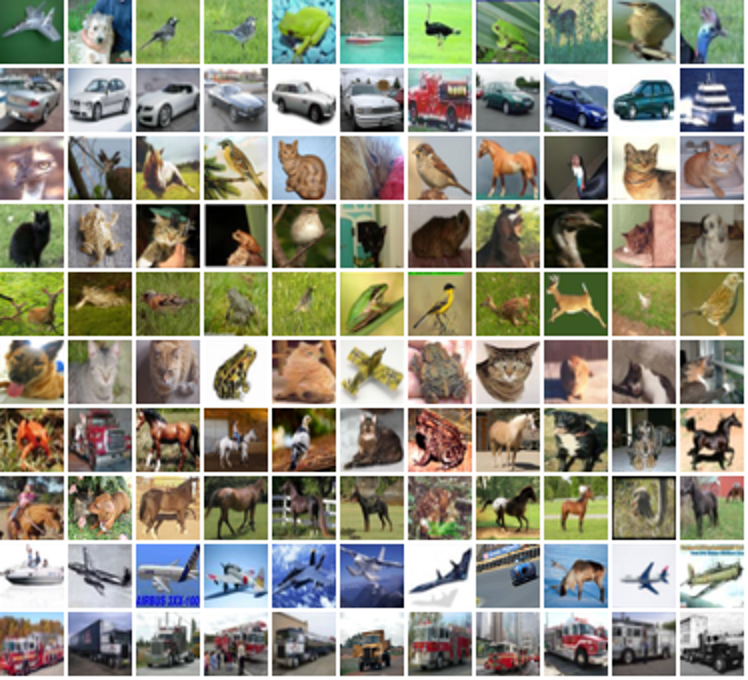

In [ ]:
near_neighbours_per_example = 10

x_test_t = paddle.to_tensor(x_test)
test_images_embeddings = model_2(x_test_t)
similarities_matrix = paddle.matmul(
    test_images_embeddings, test_images_embeddings, transpose_y=True
)

indicies = paddle.argsort(similarities_matrix, descending=True)
indicies = indicies.numpy()

examples = np.empty(
    (
        num_classes,
        near_neighbours_per_example + 1,
        3,
        height_width,
        height_width,
    ),
    dtype=np.float32,
)

for row_idx in range(num_classes):
    examples_for_class = class_idx_to_test_idxs[row_idx]
    anchor_idx = random.choice(examples_for_class)

    examples[row_idx, 0] = x_test[anchor_idx]
    anchor_near_neighbours = indicies[anchor_idx][
        1 : near_neighbours_per_example + 1
    ]
    for col_idx, nn_idx in enumerate(anchor_near_neighbours):
        examples[row_idx, col_idx + 1] = x_test[nn_idx]

show_collage(examples)

## The End

通过上述的内容，就使用 `@jit.to_static` 完成了动转静并使用该模型进行了预测，如果想了解更多关于动转静的内容，可以参考 [动态图转静态图](https://www.paddlepaddle.org.cn/documentation/docs/zh/guides/04_dygraph_to_static/index_cn.html)。